In [1]:
import datetime

import numpy as np
import pandas as pd
import hydra
import matplotlib.pyplot as plt
from matplotlib import ticker

import e3psi
import hubbardml
from hubbardml import datasets
from hubbardml import graphs
from hubbardml import keys
from hubbardml import plots

In [2]:
DATASET = '../data/data_uv_2024_1_25.json'

In [3]:
df = datasets.load(DATASET)

In [4]:
graph_data = None
with hydra.initialize(version_base="1.3", config_path="../experiments"):
    cfg = hydra.compose(config_name="config.yaml")
    graph = hydra.utils.instantiate(cfg["graph"])
    graph_data = hubbardml.GraphData(graph, cfg["dataset"])

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Att

In [5]:
species_counts = graph_data.dataset[keys.SPECIES].value_counts()
species_counts

species
(Mn)    856
(Ni)    396
(Fe)    138
Name: count, dtype: int64

Text(0, 0.5, 'Number of data points')

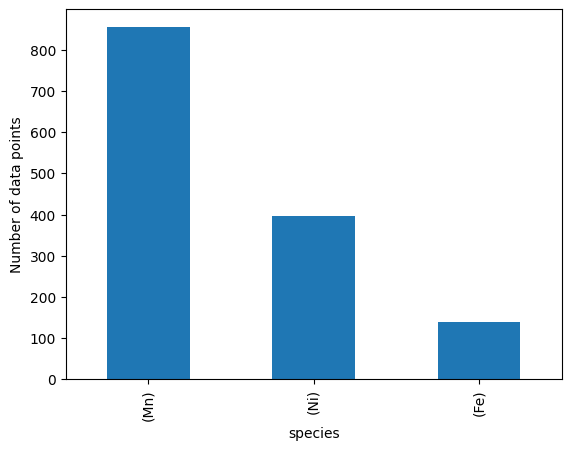

In [6]:
ax = species_counts.plot.bar()
ax.set_ylabel("Number of data points")

In [7]:
print(graph_data.dataset[keys.SPECIES].unique())
df = graph_data.identify_duplicates(
    graph_data.dataset, group_by=[keys.SPECIES]
)
# df[df[keys.TRAINING_LABEL] != keys.DUPLICATE][keys.SPECIES].value_counts()

[frozenset({'Ni'}) frozenset({'Mn'}) frozenset({'Fe'})]


/home/martin/docs/academic/projects/hubbardml/hubbardml/graphdata.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['d69d525f-e11b-4a53-ae80-14c6d8de1810'
 'd69d525f-e11b-4a53-ae80-14c6d8de1810'
 '5dbdbfbe-8525-4a46-b9a1-86a08f2f0905'
 '5dbdbfbe-8525-4a46-b9a1-86a08f2f0905'
 '5dbdbfbe-8525-4a46-b9a1-86a08f2f0905'
 '5dbdbfbe-8525-4a46-b9a1-86a08f2f0905'
 'd69d525f-e11b-4a53-ae80-14c6d8de1810'
 'd69d525f-e11b-4a53-ae80-14c6d8de1810'
 'd69d525f-e11b-4a53-ae80-14c6d8de1810'
 'd69d525f-e11b-4a53-ae80-14c6d8de1810'
 '5dbdbfbe-8525-4a46-b9a1-86a08f2f0905'
 '5dbdbfbe-8525-4a46-b9a1-86a08f2f0905'
 '5dbdbfbe-8525-4a46-b9a1-86a08f2f0905'
 '5dbdbfbe-8525-4a46-b9a1-86a08f2f0905'
 'd69d525f-e11b-4a53-ae80-14c6d8de1810'
 'd69d525f-e11b-4a53-ae80-14c6d8de1810'
 '2606d999-1db0-4c4a-b80c-08a00c61011b'
 '2606d999-1db0-4c4a-b80c-08a00c61011b'
 'bd010074-a6ba-4d36-a71a-9c121d9f3fc1'
 'bd010074-a6ba-4d36-a71a-9c121d9f3fc1

In [8]:
similarities = pd.concat([entry[2] for entry in graph_data.get_similarity_frames(group_by=['species'])])

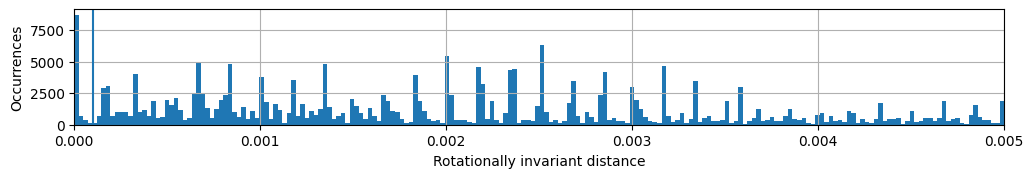

In [26]:
ax = similarities["occs_sum"].hist(bins=40000, log=False)
ax.get_figure().set_size_inches(12, 1.5)
# ax.set_xlim(left=0.)
ax.set_xlim([0, 5e-3])
ax.axvline(hubbardml.graphs.DEFAULT_OCCS_TOL)
ax.set_xlabel("Rotationally invariant distance")
ax.set_ylabel("Occurrences")
plt.savefig('img/occs_sum_distances.pdf', bbox_inches='tight')

In [22]:
ax.axvline(hubbardml.graphs.DEFAULT_OCCS_TOL)
ax

<Axes: xlabel='Rotationally invariant distance', ylabel='Occurrences'>

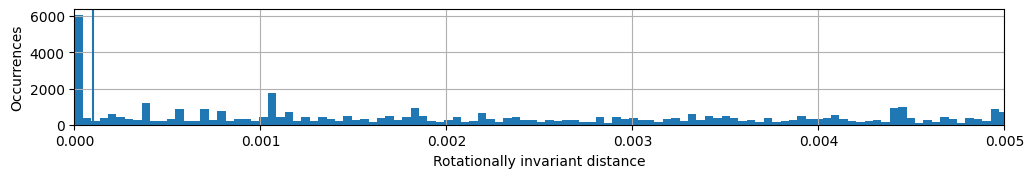

In [27]:
ax = similarities["occs_prod"].hist(bins=40000, log=False)
ax.get_figure().set_size_inches(12, 1.5)
ax.set_xlim([0, 5e-3])
ax.axvline(hubbardml.graphs.DEFAULT_OCCS_TOL)
ax.set_xlabel("Rotationally invariant distance")
ax.set_ylabel("Occurrences")
plt.savefig('img/occs_prod_distances.pdf', bbox_inches='tight')

In [12]:

def plot_param_histogram(
    df: pd.DataFrame,
    x_label: str = "Hubbard param. (eV)",
    y_label: str = "Frequency",
    title: str = None,
    param_col: str = keys.PARAM_OUT,
    bins=20,
) -> plt.Figure:
    # Plot the histogram
    fig, ax = plt.subplots()
    fig.suptitle(title)

    kwargs = dict(
        histtype='stepfilled',
        alpha=0.8,
        density=True,
        bins=bins,
        ec="k",
        stacked=True,
        # log=True,
    )
    for species, frame in df.groupby(keys.SPECIES):
        ax.hist(
            frame[param_col],
            color=frame.iloc[0][keys.COLOUR],
            label = "-".join(species),
            **kwargs,
        )

    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    fig.legend()
    return fig


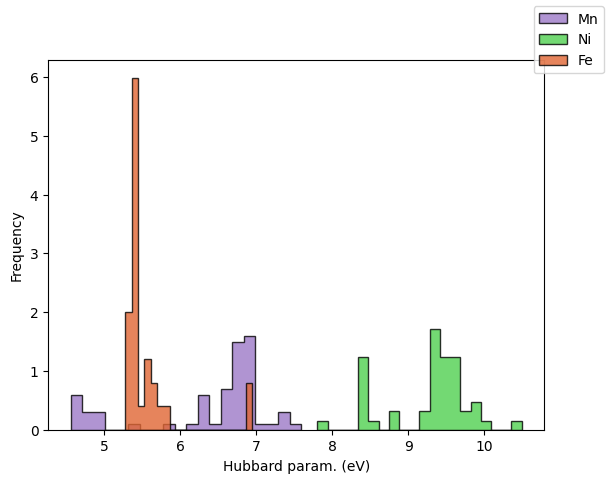

In [13]:
last_iter_subframes = []
for path, sc_rows in datasets.iter_self_consistent_paths(df):
    # Get the maximum iteration reached
    max_iter = sc_rows[keys.UV_ITER].max()
    # Get the rows containing the last iteration
    max_iter_rows = sc_rows[sc_rows[keys.UV_ITER] == max_iter]
    last_iter_subframes.append(max_iter_rows)

last_iter_frame = pd.concat(last_iter_subframes)
last_iter_frame = last_iter_frame.drop_duplicates(hubbardml.similarities.CLUSTER_ID)

# Plot the histogram
plot_param_histogram(last_iter_frame, bins=20);

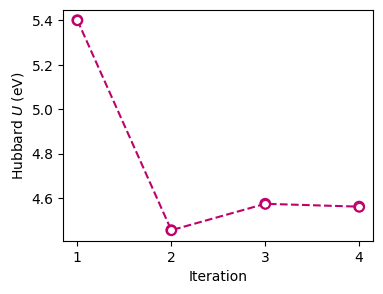

In [14]:
mn_olivines = df[df[keys.DIR].str.contains("Li1.00MnPO4")]
mn_olivines = mn_olivines[mn_olivines[keys.ATOM_1_IDX] == 1]

fig, ax = plt.subplots(figsize=(4, 3))
# ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_ylabel("Hubbard $U$ (eV)")
ax.set_xlabel("Iteration")
plots.plot_series(
    ax,
    mn_olivines[keys.UV_ITER], 
    mn_olivines[keys.PARAM_OUT],
    plots.plot_colours[1],
    label="test",
)
fig = ax.get_figure()
fig.savefig("self_consistent.pdf", bbox_inches="tight")


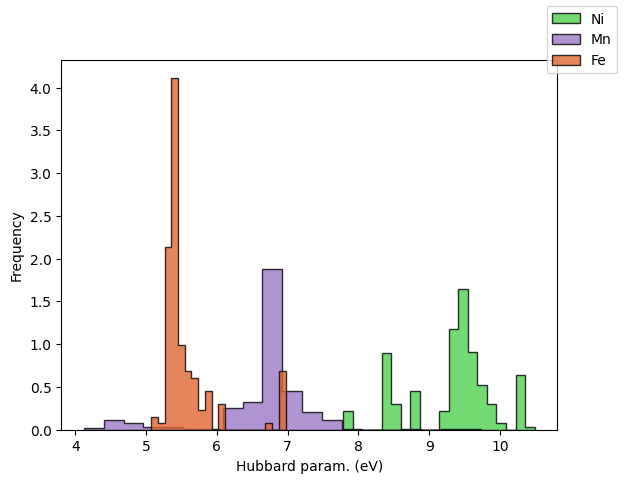

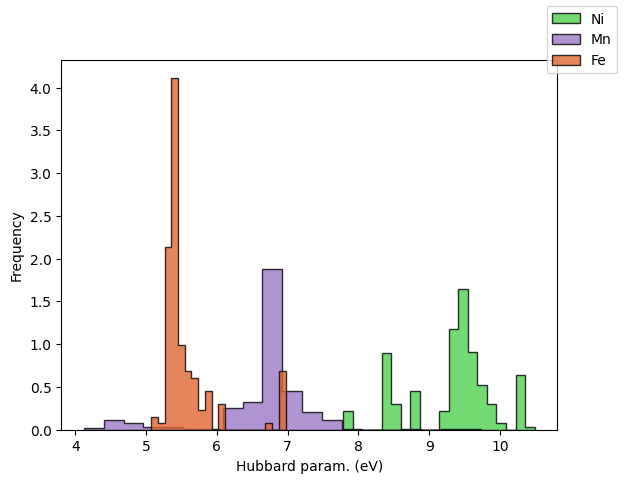

In [15]:
plot_param_histogram(df)

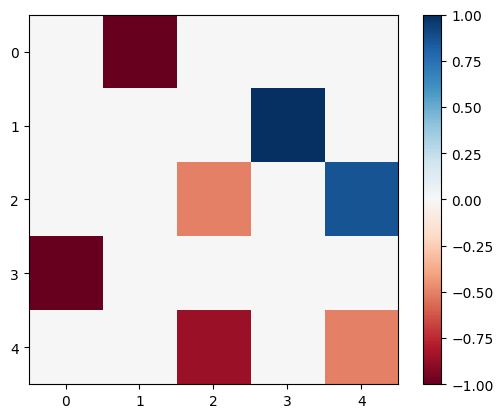

In [16]:
import torch
from e3nn import o3
import matplotlib.pyplot as plt

change_of_coord = torch.tensor([
    # this specifies the change of basis zxy -> xyz
    [0., -1., 0.],
    [0., 0., -1.],
    [1., 0., 0.]
])

D = o3.Irrep(2, 1).D_from_matrix(change_of_coord)

plt.imshow(D, cmap="RdBu", vmin=-1, vmax=1)
plt.colorbar();

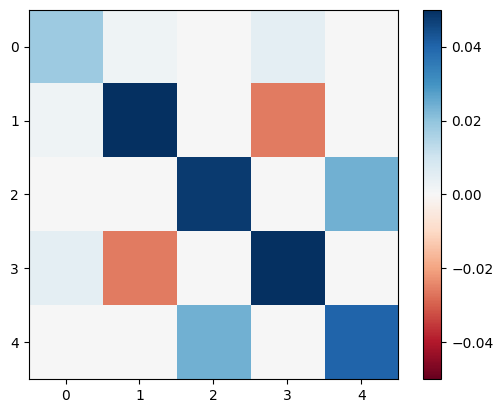

In [17]:
occu1 = torch.tensor(
    [
       [0.018,  0.002,  0.000,  0.005,  0.000],
       [0.002,  0.053, -0.000, -0.026,  0.000],
       [0.000, -0.000,  0.048,  0.000,  0.024],
       [0.005, -0.026,  0.000,  0.050, -0.000],
       [0.000,  0.000,  0.024, -0.000,  0.040],
])
plt.imshow(occu1, cmap="RdBu", vmin=-0.05, vmax=.05)
plt.colorbar();

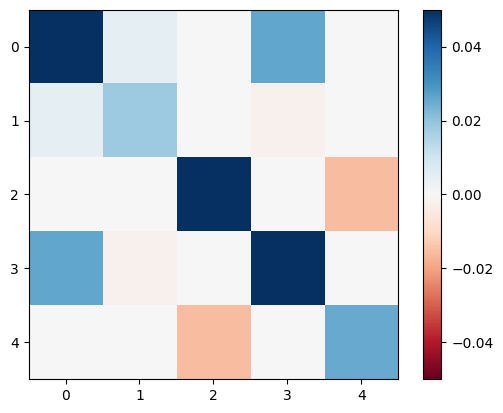

In [18]:
plt.imshow(D.T @ occu1 @ D, cmap="RdBu", vmin=-0.05, vmax=.05)
plt.colorbar();